In [1]:
!pip install pyspark

In [2]:
import socket
host_name = socket.gethostname()
ip_address = socket.gethostbyname(host_name)
print("Host name:", host_name)
print("ip_address name:", ip_address)


Host name: 192.168.1.51
IP address: 192.168.1.51


In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark import SparkConf,SparkContext
from pyspark.sql.functions import split, concat_ws
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("dataset15k.csv")

In [5]:
data = data.drop("Summary", axis=1)
data = data.drop("img_m", axis=1)
data = data.drop("img_s", axis=1)
data = data.drop("img_l", axis=1)
data = data.drop("Category", axis=1)
data['isbn'] = pd.to_numeric(data['isbn'], errors='coerce',downcast='integer')
data = data.dropna()
data['isbn'] = data['isbn'].astype(int)
data['user_id'] = data["user_id"].astype(str).str[:4]
data['isbn'] = data["isbn"].astype(str).str[:9]
new_df = data.drop("location", axis=1)

In [6]:
new_df.to_csv("newdataset.csv", index=False)

In [7]:
d = pd.read_csv("newdataset.csv")

In [8]:
d.head()

,Unnamed: 0,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,city,state,country
0,0,2,18.0000,195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,stockton,california,usa
1,1,8,34.7439,2005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,timmins,ontario,canada
2,2,1140,49.0000,2005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,ottawa,ontario,canada
3,4,4138,34.7439,2005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,sudbury,ontario,canada
4,5,6754,30.0000,2005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,toronto,ontario,canada


In [9]:
conf = SparkConf().setAppName("191805056_EsmanurDeli")
sc = SparkContext.getOrCreate(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/27 19:19:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
dataset = sc.textFile("newdataset.csv")

In [11]:
header = dataset.first()

In [12]:
data = dataset.filter(lambda line: line != header)

In [13]:
num_books = data.count()
print("Number of Books: ", num_books)

Number of Books:  13656


Visualize data

In [14]:
book_fields = data.map(lambda lines: lines.split(","))

In [15]:
book_fields.first()

['0',
 '2',
 '18.0',
 '195153448',
 '0',
 'Classical Mythology',
 'Mark P. O. Morford',
 '2002.0',
 'Oxford University Press',
 'en',
 'stockton',
 'california',
 'usa']

Gerekli yerleri nümerik değere çevirme

In [16]:
isbn = book_fields.map(lambda fields:fields[3])

In [17]:
isbn_filtered = isbn.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [18]:
user_id = book_fields.map(lambda fields:fields[1])

In [19]:
user_id_filtered=user_id.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [20]:
rating = book_fields.map(lambda fields:fields[4])

In [21]:
rating_filtered = rating.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [22]:
user_ages = book_fields.map(lambda x : float(x[2])).collect()

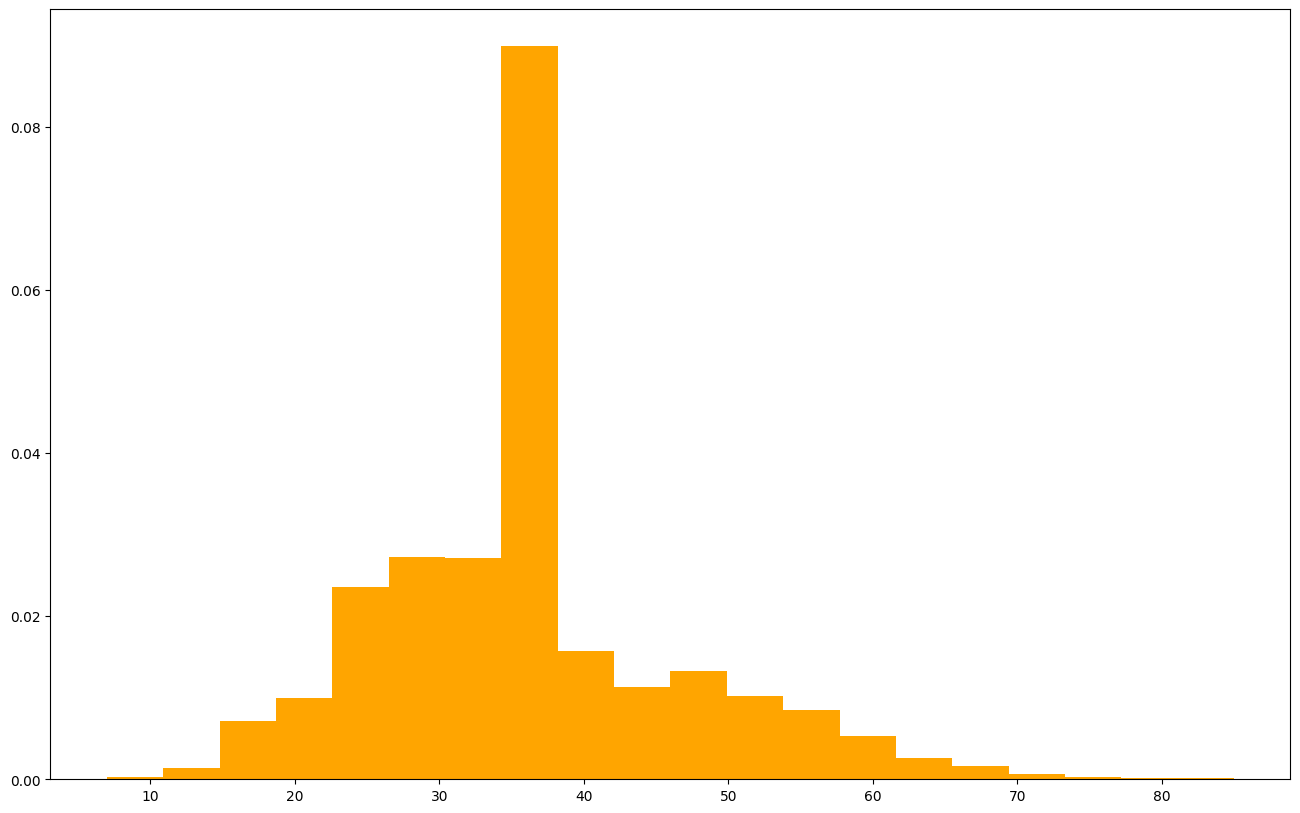

In [23]:
plt.hist(user_ages, bins=20, color="orange", density =True)
fig = plt.gcf()
fig.set_size_inches(16,10)

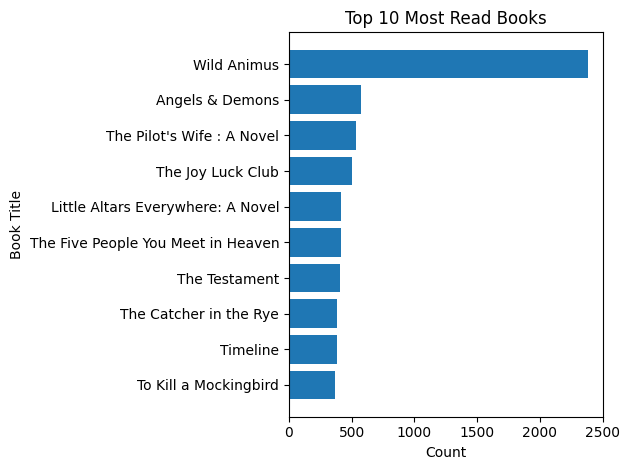

In [24]:
title_counts = book_fields.map(lambda x: (x[5], 1)).reduceByKey(lambda a, b: a + b)

titles = title_counts.collect()

sorted_titles = sorted(titles, key=lambda x: x[1], reverse=True)


top_10_titles = sorted_titles[:10]


x = [title[0] for title in top_10_titles]
y = [title[1] for title in top_10_titles]


plt.barh(x, y, align='center')
plt.xlabel("Count")
plt.ylabel("Book Title")
plt.title("Top 10 Most Read Books")

plt.gca().invert_yaxis()  
plt.tight_layout()  

plt.show()


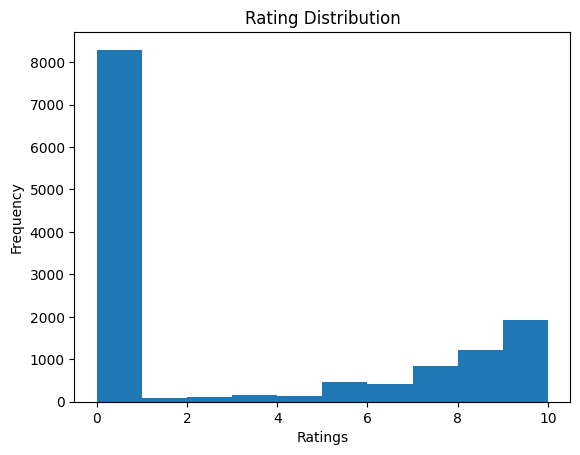

In [48]:
ratings = book_fields.map(lambda x: float(x[4])).collect()
plt.hist(ratings, bins=10)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Rating Distribution")
plt.show()

In [ ]:
publishers = book_fields.map(lambda x: (x[8], 1)).reduceByKey(lambda a, b: a + b).collect()
x = [pub[0] for pub in publishers]
y = [pub[1] for pub in publishers]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(y, autopct='%1.1f%%')
ax1.set_title('publisher Distribution')

ax2.axis('off')
table_data = [(x, y) for x, y in zip(x, y)]
table = ax2.table(cellText=table_data, colLabels=['Publisher', 'Count'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
table.auto_set_column_width([0, 1])

In [ ]:
user_id_filtered.take(3)

In [ ]:
rating.take(3)

Reduce kullanımı

In [26]:
book_ratings = data.map(lambda line: line.split(",")).map(lambda x: (x[6], int(x[4])))


In [27]:
average_ratings = book_ratings.reduceByKey(lambda x, y: (x + y) / 2)


In [28]:
for book, rating in average_ratings.collect():
    print(f"Book: {book}, Average Rating: {rating}")


Book: Mark P. O. Morford, Average Rating: 0
Book: Richard Bruce Wright, Average Rating: 6.53369140625
Book: E. J. W. Barber, Average Rating: 0
Book: Amy Tan, Average Rating: 1.6438236982113863
Book: Robert Cowley, Average Rating: 0.5
Book: Scott Turow, Average Rating: 0.0
Book: Sheila Heti, Average Rating: 2.5
Book: R. J. Kaiser, Average Rating: 5
Book: Jack Canfield, Average Rating: 5.421875
Book: Loren D. Estleman, Average Rating: 6
Book: Robert Hendrickson, Average Rating: 1.5
Book: Julia Oliver, Average Rating: 3.5
Book: John Grisham, Average Rating: 1.446900765421845
Book: Toni Morrison, Average Rating: 0.7931664225774198
Book: The Onion, Average Rating: 6.9735260009765625
Book: J. R. Parrish, Average Rating: 2.5
Book: Kathleen Duey, Average Rating: 6
Book: MICHAEL CRICHTON, Average Rating: 1.1030332792556412
Book: Rosamunde Pilcher, Average Rating: 3.0051557342651214
Book: Agatha Christie, Average Rating: 0.051239013671875
Book: Louis L'Amour, Average Rating: 3.42333984375
Book: 

Build recommendation engine using collaborative filtering.

In [29]:
from pyspark.mllib. recommendation import ALS # Alternating Least Squares 
from pyspark.mllib.recommendation import Rating
ratings = book_fields.map (lambda x: Rating(int(x[1]), int(x[3]), float(x[4])))

In [30]:
ratings.take(5)

[Rating(user=2, product=195153448, rating=0.0),
 Rating(user=8, product=2005018, rating=5.0),
 Rating(user=1140, product=2005018, rating=0.0),
 Rating(user=4138, product=2005018, rating=0.0),
 Rating(user=6754, product=2005018, rating=8.0)]

Use %70 of dataset for training, rest of them for testing.

In [31]:
training_data, test_data = ratings.randomSplit([0.7, 0.3])

In [32]:
training_data.take(10)

[Rating(user=2, product=195153448, rating=0.0),
 Rating(user=8, product=2005018, rating=5.0),
 Rating(user=1140, product=2005018, rating=0.0),
 Rating(user=4138, product=2005018, rating=0.0),
 Rating(user=6754, product=2005018, rating=8.0),
 Rating(user=9605, product=2005018, rating=0.0),
 Rating(user=1774, product=2005018, rating=0.0),
 Rating(user=2002, product=2005018, rating=8.0),
 Rating(user=2109, product=2005018, rating=9.0),
 Rating(user=2190, product=2005018, rating=7.0)]

In [33]:
training_data = training_data.map(lambda x: (x[0], x[1], int(x[2])))

In [34]:
training_data.take(10)

[(2, 195153448, 0),
 (8, 2005018, 5),
 (1140, 2005018, 0),
 (4138, 2005018, 0),
 (6754, 2005018, 8),
 (9605, 2005018, 0),
 (1774, 2005018, 0),
 (2002, 2005018, 8),
 (2109, 2005018, 9),
 (2190, 2005018, 7)]

Use ALS (Alternating Least Squares) for training recommendation model with last 4 digit
of your student number as a “seed”. Also change the parameters of ALS re-run the
algorithm for parameters “rank” (10, 50, 200), “iteration” (10, 50, 200) and “lambda”
(0.01, 0.1). 

In [35]:
from pyspark.mllib.evaluation import RegressionMetrics

seed = 5056
rank_values = [10, 50, 200]
iteration_values = [10, 50, 60]
lambda_values = [0.01, 0.1]

In [36]:
results = []
i=1
mses = []

In [37]:

for rank in rank_values:
    for iteration in iteration_values:
        for lmbda in lambda_values:
            model = ALS.train(
                training_data,
                rank=rank,
                iterations=iteration,
                lambda_=lmbda,
                seed=seed
            )

            
            test_user_product = test_data.map(lambda x: (x[0], x[1]))
            predictions = model.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
            rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
            mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
            rmse = mse**0.5

            result = {
                "Model" : i,
                'Rank': rank,
                'Iterations': iteration,
                'Lambda': lmbda,
                'MSE': mse,
                'RMSE': rmse
            }
            results.append(result)
            mses.append(mse)
            

            print("Model {} Parameters: Rank={}, Iterations={}, Lambda={}".format(i,rank, iteration, lmbda))
            print("MSE:", mse)
            print("RMSE:", rmse)
            print("-------------------------------")
            i+=1

23/05/27 19:20:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/27 19:20:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/05/27 19:20:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Model 1 Parameters: Rank=10, Iterations=10, Lambda=0.01
MSE: 40.12592428318046
RMSE: 6.334502686334615
-------------------------------


Model 2 Parameters: Rank=10, Iterations=10, Lambda=0.1
MSE: 21.959635074562165
RMSE: 4.686110868786841
-------------------------------
Model 3 Parameters: Rank=10, Iterations=50, Lambda=0.01
MSE: 28.220672989824244
RMSE: 5.312313336939402
-------------------------------
Model 4 Parameters: Rank=10, Iterations=50, Lambda=0.1
MSE: 20.829040420439597
RMSE: 4.563884356602345
-------------------------------


Model 5 Parameters: Rank=10, Iterations=60, Lambda=0.01
MSE: 27.397655126583366
RMSE: 5.23427694400892
-------------------------------
Model 6 Parameters: Rank=10, Iterations=60, Lambda=0.1
MSE: 20.78035643494279
RMSE: 4.558547623415027
-------------------------------
Model 7 Parameters: Rank=50, Iterations=10, Lambda=0.01
MSE: 19.18983618847727
RMSE: 4.380620525505178
-------------------------------


Model 8 Parameters: Rank=50, Iterations=10, Lambda=0.1
MSE: 18.3800564762466
RMSE: 4.287196808667244
-------------------------------
Model 9 Parameters: Rank=50, Iterations=50, Lambda=0.01
MSE: 17.793013484997275
RMSE: 4.2181765592489455
-------------------------------


Model 10 Parameters: Rank=50, Iterations=50, Lambda=0.1
MSE: 17.992438306542944
RMSE: 4.241749439387355
-------------------------------
Model 11 Parameters: Rank=50, Iterations=60, Lambda=0.01
MSE: 17.76127382078166
RMSE: 4.214412630578745
-------------------------------


Model 12 Parameters: Rank=50, Iterations=60, Lambda=0.1
MSE: 17.995578095243292
RMSE: 4.242119528636987
-------------------------------


Model 13 Parameters: Rank=200, Iterations=10, Lambda=0.01
MSE: 17.68133169094947
RMSE: 4.2049175605414035
-------------------------------


Model 14 Parameters: Rank=200, Iterations=10, Lambda=0.1
MSE: 18.109918305060813
RMSE: 4.255574967623154
-------------------------------


Model 15 Parameters: Rank=200, Iterations=50, Lambda=0.01
MSE: 17.675094484578434
RMSE: 4.204175838922349
-------------------------------


Model 16 Parameters: Rank=200, Iterations=50, Lambda=0.1
MSE: 17.976486272830904
RMSE: 4.239868662214775
-------------------------------


Model 17 Parameters: Rank=200, Iterations=60, Lambda=0.01
MSE: 17.686271141571556
RMSE: 4.20550486167494
-------------------------------


Model 18 Parameters: Rank=200, Iterations=60, Lambda=0.1
MSE: 17.98225166985828
RMSE: 4.240548510494636
-------------------------------


ALS'yi farklı parametreler ile çalıştırıp, farklı parametrelerin karşılaştırmalı performans sonucunu, yazdığınız programda (i.e. pyspark - Jupiter notebook ) plot ile görselleştirmelisiniz.

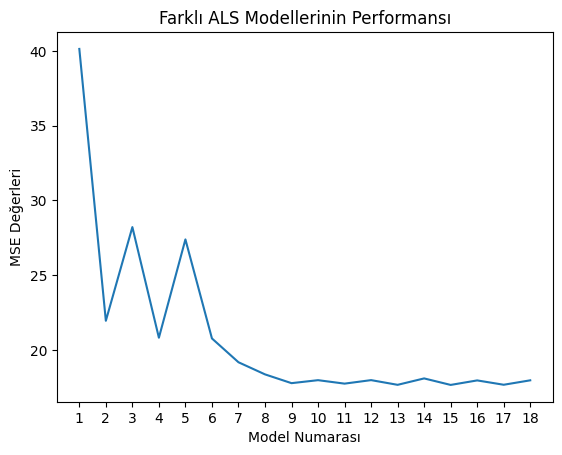

In [38]:
import matplotlib.pyplot as plt

x = range(1,19) 
y = mses  

# Grafik oluşturma
plt.plot(x, y)
plt.xlabel('Model Numarası')
plt.ylabel('MSE Değerleri')
plt.title('Farklı ALS Modellerinin Performansı')
plt.xticks(range(1, 19)) 

plt.show()


In [40]:
print(min(mses),mses.index(min(mses)))

17.675094484578434 14


In [41]:
model15 = ALS.train(
                training_data,
                rank=200,
                iterations=50,
                lambda_=0.01,
                seed=5056
            )

ALS ile tahminde bulunup (predict) bunu yan yana gelecek şekilde orijinal (gerçek değerler ile) değerlendirmeler ile karşılaştırması olmalı. En iyi model ile bunu yapıyoruz

In [43]:
test_data = test_data.collect()

for row in test_data[:100]:
    user_id = row.user
    item_id = row.product
    rating = row.rating
    
    if model15.userFeatures().lookup(user_id) and model15.productFeatures().lookup(item_id):
        predicted_rating = model15.predict(user_id, item_id)

        print("Gerçek Değer: {}, Tahmin: {}".format(rating, predicted_rating))

Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 9.0, Tahmin: 1.6716087154553496
Gerçek Değer: 6.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.9473660319078443
Gerçek Değer: 8.0, Tahmin: 1.4526278578413643
Gerçek Değer: 6.0, Tahmin: -0.2005738786684499
Gerçek Değer: 9.0, Tahmin: 0.0
Gerçek Değer: 10.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 2.5255603342426456
Gerçek Değer: 8.0, Tahmin: -0.9527121029988375
Gerçek Değer: 7.0, Tahmin: 2.3749553738412477
Gerçek Değer: 0.0, Tahmin: 7.344382244804679
Gerçek Değer: 5.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.24772617075899056
Gerçek Değer: 0.0, Tahmin: 0.5329622570182286
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 10.0, Tahmin: -0.49389740414891653
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.0003158454296019464
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 8.0, Tahmin: -0.2855411780115634
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, T

ALS modeli ile ürünler arasındaki kosinüs benzerliği (cosine similarity) bulunmalı ve X ürününü en çok sevecek 10 kullanıcı belirlenmeli. 

In [44]:
def cosinesimilarity(item_id, a, b):
    dot = np.dot (a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return cos

In [45]:
import numpy as np

unique_item_ids = set()

for row in test_data[:100]:
    item_id = row.product
    rating = row.rating
    
    if item_id not in unique_item_ids: 
        unique_item_ids.add(item_id)
    
        if model15.productFeatures().lookup(item_id):
      
            item_vector = model15.productFeatures ().lookup(item_id)[0]
            cos = cosinesimilarity(item_id, item_vector, item_vector)
            print("İtem: {}, cosine similarity: {}".format(item_id, cos))

İtem: 2005018, cosine similarity: 1.0
İtem: 374157065, cosine similarity: 1.0
İtem: 399135782, cosine similarity: 1.0


/var/folders/4p/4qnh8s0n31s8tylgw5vp1r1r0000gn/T/ipykernel_20852/2317248424.py:5: RuntimeWarning: invalid value encountered in double_scalars
  cos = dot / (norma * normb)


İtem: 425176428, cosine similarity: nan
İtem: 671870432, cosine similarity: nan
İtem: 771074670, cosine similarity: 1.0000000000000002
İtem: 155874621, cosine similarity: 1.0000000000000002
İtem: 440234743, cosine similarity: 0.9999999999999999


In [46]:
productID = 440234743
K = 10

topKitem = model15.recommendUsers(productID,K)

for i in topKitem:
    print(i)

Rating(user=7816, product=440234743, rating=9.995673543512677)
Rating(user=6853, product=440234743, rating=9.995673543512677)
Rating(user=1504, product=440234743, rating=9.993501701390874)
Rating(user=9364, product=440234743, rating=9.993351922007658)
Rating(user=2409, product=440234743, rating=9.99116451246047)
Rating(user=1440, product=440234743, rating=9.989040458663432)
Rating(user=1292, product=440234743, rating=9.988836278629524)
Rating(user=2748, product=440234743, rating=9.988167678239114)
Rating(user=1133, product=440234743, rating=9.987328648576199)
Rating(user=1468, product=440234743, rating=9.986367046366688)
